<a href="https://colab.research.google.com/github/kemaladamr/NLP_Fundamentals/blob/main/Developing_Text_Cassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hierarchical Clustering

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sklearn.datasets import fetch_20newsgroups
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib as mpl
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
categories = ['misc.forsale', 'sci.electronics', 'talk.religion.misc']

In [5]:
news_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True,
                               random_state=42, download_if_missing=True
                               )

In [6]:
news_data['data'][:5]

['From: Steve@Busop.cit.wayne.edu (Steve Teolis)\nSubject: Re: *** TurboGrafx System For SALE ***\nOrganization: Wayne State University\nLines: 38\nDistribution: na\nNNTP-Posting-Host: 141.217.75.24\n\n>TurboGrafx-16 Base Unit (works like new) with:\n>       1 Controller\n>       AC Adapter\n>       Antenna hookup\n>     * Games:\n>         Kieth Courage\n>         Victory Run\n>         Fantasy Zone\n>         Military Madness\n>         Battle Royal\n>         Legendary Axe\n>         Blazing Lasers\n>         Bloody Wolf\n>\n>  --------------------------------------\n>* Will sell games separatley at $25 each\n>  --------------------------------------\n\nYour kidding, $210.00, man o man, you can buy the system new for $49.00 at \nElectronic Boutique and those games are only about $15 - $20.00 brand new.  \nMaybe you should think about that price again if you REALLY need the money.\n\n\n\n\n\n\n                        \n                        \n                        -=-=-=-=-=-=-=-

In [7]:
news_data.target

array([0, 0, 1, ..., 0, 1, 0])

In [8]:
news_data.target_names

['misc.forsale', 'sci.electronics', 'talk.religion.misc']

In [9]:
news_data_df = pd.DataFrame({'text': news_data['data'], 'category': news_data.target})
news_data_df.head()

,text,category
0,From: Steve@Busop.cit.wayne.edu (Steve Teolis)...,0
1,From: jks2x@holmes.acc.Virginia.EDU (Jason K. ...,0
2,From: wayne@uva386.schools.virginia.edu (Tony ...,1
3,From: lihan@ccwf.cc.utexas.edu (Bruce G. Bostw...,1
4,From: myoakam@cis.ohio-state.edu (micah r yoak...,0


In [10]:
news_data_df['category'].value_counts()

1    591
0    585
2    377
Name: category, dtype: int64

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [12]:
news_data_df['cleaned_text'] = news_data_df['text'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word.lower())
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))
    if word.lower() not in stop_words])
)

In [13]:
tfidf_model = TfidfVectorizer(max_features=200)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(news_data_df['cleaned_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,00,10,100,12,14,15,16,20,25,30,40,50,ac,also,amp,another,anyone,apple,around,article,asking,back,believe,best,better,bible,bit,board,book,box,brian,ca,cable,call,car,card,case,cc,cd,child,...,service,set,shipping,since,software,someone,something,sound,source,state,still,subject,sure,system,take,thanks,thing,think,time,true,two,university,usa,use,used,using,value,version,want,way,well,wire,wiring,without,word,work,world,would,writes,year
0,0.435655,0.0,0.000000,0.0,0.000000,0.127775,0.136811,0.127551,0.133311,0.0,0.0,0.0,0.1496,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125162,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.251172,0.0,0.040491,0.0,0.227027,0.0,0.0,0.0,0.116296,0.0,0.0,0.0,0.154615,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.113042,0.000000,0.000000,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.294937,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.376762,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.390137,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.093464,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.178445,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.6485,0.0,0.000000,0.0,0.177319,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.474376,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.128216,0.000000,0.0,0.139195,0.0,0.0,0.099153,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.559678,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1578,0.0000,0.0,0.152058,0.0,0.049026,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.093603,0.130822,0.0,0.000000,0.0,0.0,0.0,0.134289,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142267,0.106317,0.100306,0.0
4,0.000000,0.0,0.207003,0.0,0.191897,0.182138,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.210041,0.0,0.0,0.18822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.537053,0.0,0.057719,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.110198,0.154017,0.0,0.154412,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [14]:
dist = 1 - cosine_similarity(tfidf_df)
linkage_matrix = ward(dist)

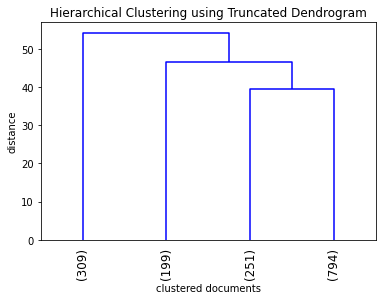

In [15]:
# Truncating the Dendrogram Truncation to show last 4 clusters
plt.title('Hierarchical Clustering using Truncated Dendrogram')
plt.xlabel('clustered documents')
plt.ylabel('distance')
dendrogram(
    linkage_matrix,
    truncate_mode='lastp', # showing only last p clustering after merging
    p=4, # p is the number of cluster that should remain after merging
    leaf_rotation=90.,
    leaf_font_size=12.
)
plt.show()

In [16]:
k = 4
clusters = fcluster(linkage_matrix, k, criterion='maxclust')
clusters

array([3, 3, 3, ..., 4, 4, 1], dtype=int32)

In [17]:
news_data_df['obtained_clusters'] = clusters
pd.crosstab(news_data_df['category'].replace({0:'misc.forsale',
                                              1:'sci.electronics',
                                              2:'talk.religion.misc'}),
            news_data_df['obtained_clusters'].replace({1:'cluster_1',
                                                       2:'cluster_2',
                                                       3:'cluster_3',
                                                       4:'cluster_4'})
            )

obtained_clusters,cluster_1,cluster_2,cluster_3,cluster_4
category,,,,
misc.forsale,155,0,230,200
sci.electronics,110,1,19,461
talk.religion.misc,44,198,2,133


## K-Means Clustering

In [18]:
import seaborn as sns;
sns.set()
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [19]:
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)
lemmatizer = WordNetLemmatizer()

In [20]:
categories = ['misc.forsale', 'sci.electronics', 'talk.religion.misc']

In [21]:
news_data = fetch_20newsgroups(subset='train', categories=categories,
                               shuffle=True, random_state=42, download_if_missing=True)

In [22]:
news_data_df = pd.DataFrame({'text': news_data['data'], 'category': news_data.target})
news_data_df.head()

news_data_df['cleaned_text'] = news_data_df['text'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word.lower())
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))
    if word.lower() not in stop_words])
)

In [23]:
tfidf_model = TfidfVectorizer(max_features=200)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(news_data_df['cleaned_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,00,10,100,12,14,15,16,20,25,30,40,50,ac,also,amp,another,anyone,apple,around,article,asking,back,believe,best,better,bible,bit,board,book,box,brian,ca,cable,call,car,card,case,cc,cd,child,...,service,set,shipping,since,software,someone,something,sound,source,state,still,subject,sure,system,take,thanks,thing,think,time,true,two,university,usa,use,used,using,value,version,want,way,well,wire,wiring,without,word,work,world,would,writes,year
0,0.435655,0.0,0.000000,0.0,0.000000,0.127775,0.136811,0.127551,0.133311,0.0,0.0,0.0,0.1496,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125162,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.251172,0.0,0.040491,0.0,0.227027,0.0,0.0,0.0,0.116296,0.0,0.0,0.0,0.154615,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.113042,0.000000,0.000000,0.000000,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.294937,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.376762,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.390137,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000000,0.0,0.093464,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.178445,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.6485,0.0,0.000000,0.0,0.177319,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.474376,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.128216,0.000000,0.0,0.139195,0.0,0.0,0.099153,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.559678,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.1578,0.0000,0.0,0.152058,0.0,0.049026,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.093603,0.130822,0.0,0.000000,0.0,0.0,0.0,0.134289,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142267,0.106317,0.100306,0.0
4,0.000000,0.0,0.207003,0.0,0.191897,0.182138,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.210041,0.0,0.0,0.18822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.537053,0.0,0.057719,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.110198,0.154017,0.0,0.154412,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0


In [24]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tfidf_df)
y_kmeans = kmeans.predict(tfidf_df)
news_data_df['obtained_clusters'] = y_kmeans

In [25]:
pd.crosstab(news_data_df['category'].replace({0:'misc.forsale',
                                              1:'sci.electronics',
                                              2:'talk.religion.misc'}),
            news_data_df['obtained_clusters'].replace({0:'cluster_1',
                                                       1:'cluster_2',
                                                       2:'cluster_3',
                                                       3:'cluster_4'})
            )

obtained_clusters,cluster_1,cluster_2,cluster_3,cluster_4
category,,,,
misc.forsale,98,343,143,1
sci.electronics,425,9,157,0
talk.religion.misc,75,0,75,227


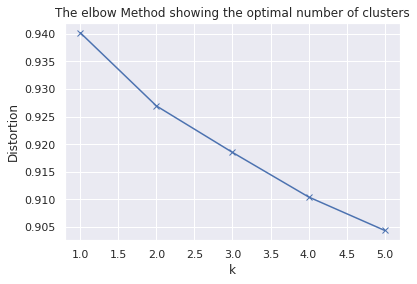

In [26]:
distortions = []
K = range(1,6)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_df)
    distortions.append(sum(np.min(cdist(tfidf_df, kmeanModel.cluster_centers_,
                                       'euclidean'), axis=1))/tfidf_df.shape[0])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The elbow Method showing the optimal number of clusters')
plt.show()

## Text Classification (Logistic regression, Naive Bayes, and KNN)

In [28]:
review_data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/NLP-PACKT/reviews_Musical_Instruments_5.json',
                           lines=True)
review_data[['reviewText', 'overall']].head()

,reviewText,overall
0,"Not much to write about here, but it does exac...",5
1,The product does exactly as it should and is q...,5
2,The primary job of this device is to block the...,5
3,Nice windscreen protects my MXL mic and preven...,5
4,This pop filter is great. It looks and perform...,5


In [29]:
lemmatizer = WordNetLemmatizer()
review_data['cleaned_review_text'] = review_data['reviewText'].apply(\
    lambda x: ' '.join([lemmatizer.lemmatize(word.lower()) \
                        for word in word_tokenize(re.sub(r'([^\s\w]|_)+',
                                                        ' ', str(x)))]))

In [30]:
review_data[['cleaned_review_text', 'reviewText', 'overall']].head()

,cleaned_review_text,reviewText,overall
0,not much to write about here but it doe exactl...,"Not much to write about here, but it does exac...",5
1,the product doe exactly a it should and is qui...,The product does exactly as it should and is q...,5
2,the primary job of this device is to block the...,The primary job of this device is to block the...,5
3,nice windscreen protects my mxl mic and preven...,Nice windscreen protects my MXL mic and preven...,5
4,this pop filter is great it look and performs ...,This pop filter is great. It looks and perform...,5


In [31]:
tfidf_model = TfidfVectorizer(max_features=500)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(
    review_data['cleaned_review_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,10,100,12,20,34,able,about,accurate,acoustic,actually,adapter,add,addario,after,again,all,almost,already,also,although,always,am,amazing,amazon,amp,an,and,another,any,anyone,anything,are,around,at,audio,away,awesome,back,bad,bag,...,usb,use,used,using,value,ve,very,vocal,volume,wa,want,wanted,wave,way,we,week,weight,well,went,were,what,when,where,which,while,who,why,will,with,without,won,work,worked,worth,would,wrong,year,yet,you,your
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.159684,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.23365,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.118288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133133,0.0,0.0,0.154309,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.134327,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.120794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.187278,0.128581,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.10478,0.0,0.0,0.0,0.0,0.00000,0.00000,0.173626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084677,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.092078,0.063028,0.0,0.0,0.085436,0.0,0.0,0.000000,0.0,0.0,0.0,0.067074,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.051043,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.17443,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.166316,0.0,0.149568,0.0,0.0,0.000000,0.150124,0.0,0.0,0.000000,0.0,0.0,0.115312,0.0,0.0,0.0,0.079880,0.111989
3,0.0,0.0,0.0,0.0,0.0,0.339573,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.185013,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.097003,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.41078,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.21104,0.000000,0.0,0.000000,0.0,0.0,0.208395,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.303608,0.000000


In [32]:
review_data['target'] = review_data['overall'].apply(lambda x: 0 if x<=4 else 1)
review_data['target'].value_counts()

1    6938
0    3323
Name: target, dtype: int64

In [33]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(tfidf_df, review_data['target'])
predicted_labels = logreg.predict(tfidf_df)
logreg.predict_proba(tfidf_df)[:,1]

array([0.57146961, 0.68579907, 0.56068939, ..., 0.65979968, 0.5495679 ,
       0.21186011])

In [34]:
review_data['predicted_labels'] = predicted_labels
pd.crosstab(review_data['target'], review_data['predicted_labels'])

predicted_labels,0,1
target,,
0,1543,1780
1,626,6312


In [35]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(tfidf_df, review_data['target'])
predicted_labels = nb.predict(tfidf_df)
nb.predict_proba(tfidf_df)[:,1]

array([9.97730158e-01, 3.63599675e-09, 9.45692105e-07, ...,
       2.46001047e-02, 3.43660991e-08, 1.72767906e-27])

In [36]:
review_data['predicted_labels_nb'] = predicted_labels
pd.crosstab(review_data['target'], review_data['predicted_labels_nb'])

predicted_labels_nb,0,1
target,,
0,2333,990
1,2380,4558


In [37]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(tfidf_df, review_data['target'])
review_data['predicted_labels_knn'] = knn.predict(tfidf_df)
pd.crosstab(review_data['target'], review_data['predicted_labels_knn'])

predicted_labels_knn,0,1
target,,
0,2643,680
1,283,6655


## Regression Analysis using Textual Data

In [38]:
reciew_data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/NLP-PACKT/reviews_Musical_Instruments_5.json', \
                           lines=True)
review_data[['reviewText', 'overall']].head()

,reviewText,overall
0,"Not much to write about here, but it does exac...",5
1,The product does exactly as it should and is q...,5
2,The primary job of this device is to block the...,5
3,Nice windscreen protects my MXL mic and preven...,5
4,This pop filter is great. It looks and perform...,5


In [39]:
lemmatizer = WordNetLemmatizer()
review_data['cleaned_review_text'] = review_data['reviewText']\
.apply(lambda x: ' '.join([lemmatizer.lemmatize(word.lower())\
                           for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))]))
review_data[['cleaned_review_text', 'reviewText', 'overall']].head()

,cleaned_review_text,reviewText,overall
0,not much to write about here but it doe exactl...,"Not much to write about here, but it does exac...",5
1,the product doe exactly a it should and is qui...,The product does exactly as it should and is q...,5
2,the primary job of this device is to block the...,The primary job of this device is to block the...,5
3,nice windscreen protects my mxl mic and preven...,Nice windscreen protects my MXL mic and preven...,5
4,this pop filter is great it look and performs ...,This pop filter is great. It looks and perform...,5


In [40]:
fromtfidf_model = TfidfVectorizer(max_features=500)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(review_data['cleaned_review_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,10,100,12,20,34,able,about,accurate,acoustic,actually,adapter,add,addario,after,again,all,almost,already,also,although,always,am,amazing,amazon,amp,an,and,another,any,anyone,anything,are,around,at,audio,away,awesome,back,bad,bag,...,usb,use,used,using,value,ve,very,vocal,volume,wa,want,wanted,wave,way,we,week,weight,well,went,were,what,when,where,which,while,who,why,will,with,without,won,work,worked,worth,would,wrong,year,yet,you,your
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.159684,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.23365,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.118288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133133,0.0,0.0,0.154309,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.134327,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.120794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.187278,0.128581,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.10478,0.0,0.0,0.0,0.0,0.00000,0.00000,0.173626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084677,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.092078,0.063028,0.0,0.0,0.085436,0.0,0.0,0.000000,0.0,0.0,0.0,0.067074,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.051043,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.17443,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.166316,0.0,0.149568,0.0,0.0,0.000000,0.150124,0.0,0.0,0.000000,0.0,0.0,0.115312,0.0,0.0,0.0,0.079880,0.111989
3,0.0,0.0,0.0,0.0,0.0,0.339573,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.185013,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.097003,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.41078,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.21104,0.000000,0.0,0.000000,0.0,0.0,0.208395,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.303608,0.000000


In [41]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(tfidf_df, review_data['overall'])
linreg.coef_

array([-1.93271993e-01,  5.65226131e-01,  5.63243687e-01, -1.84418658e-01,
       -6.32257431e-02,  3.05320627e-01,  4.95264614e-01,  5.21333693e-01,
        2.65736989e-01,  4.00058256e-01,  5.64020424e-01,  7.56022958e-01,
        1.00174846e-02, -3.06429115e-01, -3.12104234e-01,  3.38294736e-01,
       -6.05747380e-01, -1.04123996e-01,  5.58669738e-02, -1.13320890e-01,
        4.79471129e-01,  1.49528459e-01,  7.79094545e-01, -3.63399268e-01,
        1.25993539e-01, -6.29415062e-02,  4.94517373e-01, -3.34989132e-01,
        2.55374355e-01,  8.84676972e-02, -3.68013360e-01, -1.09910777e-01,
       -7.09777794e-03, -5.15547511e-02,  1.17415090e-01, -8.89213726e-02,
        1.06398798e+00, -1.19791236e+00, -1.14906460e+00,  1.55215016e-01,
       -5.05283241e-01,  2.43200389e-01,  8.56413437e-02, -3.74044994e-02,
       -7.31390217e-03,  9.63911076e-01, -7.82062558e-02,  1.50616236e-01,
       -9.35299622e-02,  1.87239631e-02,  9.34145997e-02,  1.18038260e+00,
       -3.79855115e-01,  

In [42]:
linreg.intercept_

4.218882428983382

In [43]:
linreg.predict(tfidf_df)

array([4.19200071, 4.25771652, 4.23084868, ..., 4.40384767, 4.49036403,
       4.14791976])

In [44]:
review_data['predicted_score_from_linear_regression'] = linreg.predict(tfidf_df)
review_data[['overall', 'predicted_score_from_linear_regression']].head(10)

,overall,predicted_score_from_linear_regression
0,5,4.192001
1,5,4.257717
2,5,4.230849
3,5,4.085927
4,5,4.851061
5,5,4.955069
6,5,4.446274
7,3,3.888593
8,5,4.941788
9,5,4.513824


## Tree-Based Methods (Decision Tree, Random Forest, GBM, and XGBoost)

In [45]:
data_patio_lawn_garden = pd.read_json('/content/drive/MyDrive/Colab Notebooks/NLP-PACKT/reviews_Patio_Lawn_and_Garden_5.json',
                                      lines=True)
data_patio_lawn_garden[['reviewText', 'overall']].head()

,reviewText,overall
0,Good USA company that stands behind their prod...,4
1,This is a high quality 8 ply hose. I have had ...,5
2,It's probably one of the best hoses I've ever ...,4
3,I probably should have bought something a bit ...,5
4,I bought three of these 5/8-inch Flexogen hose...,5


In [46]:
lemmatizer = WordNetLemmatizer()

In [47]:
data_patio_lawn_garden['cleaned_review_text'] = data_patio_lawn_garden['reviewText'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word.lower())\
                       for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))])
)

data_patio_lawn_garden[['cleaned_review_text', 'reviewText', 'overall']].head()

,cleaned_review_text,reviewText,overall
0,good usa company that stand behind their produ...,Good USA company that stands behind their prod...,4
1,this is a high quality 8 ply hose i have had g...,This is a high quality 8 ply hose. I have had ...,5
2,it s probably one of the best hose i ve ever h...,It's probably one of the best hoses I've ever ...,4
3,i probably should have bought something a bit ...,I probably should have bought something a bit ...,5
4,i bought three of these 5 8 inch flexogen hose...,I bought three of these 5/8-inch Flexogen hose...,5


In [48]:
tfidf_model = TfidfVectorizer(max_features=500)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(
    data_patio_lawn_garden['cleaned_review_text']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,10,20,34,8217,able,about,actually,add,after,again,ago,all,almost,along,already,also,although,always,am,amazon,amount,an,and,animal,another,ant,any,anything,are,area,around,at,away,back,bad,bag,bait,base,battery,be,...,want,wanted,water,way,we,weather,weber,weed,week,weight,well,went,were,what,when,where,which,while,who,whole,why,will,window,winter,wire,with,within,without,won,wood,work,worked,working,worth,would,yard,year,yet,you,your
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.120568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136725,0.0,0.0,0.106966,0.152116,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.147202,0.000000,0.187987,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.151395,0.000000,0.0,0.193616,0.000000,0.000000,0.099633,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.193616,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.161561,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.107205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.044132,0.146442,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.060733,0.054231,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.057724,0.0,0.218489,0.0,0.0,0.000000,0.0,0.0,0.000000,0.072988,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.116830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116566,0.0,0.216988,0.000000,0.049357
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.105608,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.064347,0.0,0.0,0.070857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.089397,0.0,0.0,0.0,0.0,0.0,0.0,0.086545,0.073217,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.098497,...,0.000000,0.0,0.000000,0.0,0.0,0.114479,0.0,0.0,0.000000,0.103964,0.0,0.000000,0.079797,0.073472,0.000000,0.0,0.068507,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083019,0.0,0.000000,0.000000,0.000000


In [49]:
data_patio_lawn_garden['target'] = data_patio_lawn_garden['overall'].apply(
    lambda x: 0 if x<=4 else 1
)

data_patio_lawn_garden['target'].value_counts()

1    7037
0    6235
Name: target, dtype: int64

In [50]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(tfidf_df, data_patio_lawn_garden['target'])
data_patio_lawn_garden['predicted_labels_dtc'] = dtc.predict(tfidf_df)

In [51]:
pd.crosstab(data_patio_lawn_garden['target'], data_patio_lawn_garden['predicted_labels_dtc'])

predicted_labels_dtc,0,1
target,,
0,6227,8
1,1,7036


In [53]:
dtr = tree.DecisionTreeRegressor()
dtr = dtr.fit(tfidf_df, data_patio_lawn_garden['overall'])
data_patio_lawn_garden['predicted_values_dtr'] = dtr.predict(tfidf_df)
data_patio_lawn_garden[['predicted_values_dtr', 'overall']].head(10)

,predicted_values_dtr,overall
0,4.0,4
1,5.0,5
2,4.0,4
3,5.0,5
4,5.0,5
5,5.0,5
6,5.0,5
7,5.0,5
8,5.0,5
9,4.0,4


In [54]:
def clf_model(model_type, Xtrain, y):
    model = model_type.fit(X_train, y)
    predicted_labels = model.predict(tfidf_df)
    return predicted_labels